# Volatility estimation using GARCH model

<b>GARCH (Generalized AutoRegressive Conditional Heteroskedasticity)</b> model is an approach to estimate volatility. The equation of the <b>GARCH(1, 1)</b> model:

$$
\begin{equation}
    \sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
\end{equation}
$$
​
Where:
* $ \sigma_t^2 $ - conditional volatility (volatility of a random variable given some extra information) at time $ t $
* $ \omega $ is the constant term
* $ \alpha $ is the coefficient of the lagged squared error term
* $ \varepsilon_{t-1}^2 $ is the squared error term at time $ t-1 $
* $ \beta $ is the coefficient of the lagged conditional variance term
* $ \sigma_{t-1}^2 $ is the conditional variance at time $ t-1 $

GARCH model is more developed ARCH (AutoRegressive Conditional Heteroskedasticity) as it assumes that the variance of the error term follows an autoregressive moving average process. The main idea is to capture volatility clustering. It means that large changes are followed by large changes, and small changes are followed by small changes. That is the reason why we include past realizations in the equation.

In this notebook, I will estimate the returns volatility of Microsoft adjusted close price.

The notebook was created with this tutorial video: https://www.youtube.com/watch?v=NKHQiN-08S8


In [94]:
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import math

data = yf.download("MSFT", start="2018-01-01", end="2023-12-01")
data['Returns'] = 100 * data['Adj Close'].pct_change()
returns = data['Returns'].dropna()

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'Microsft adjusted close price')

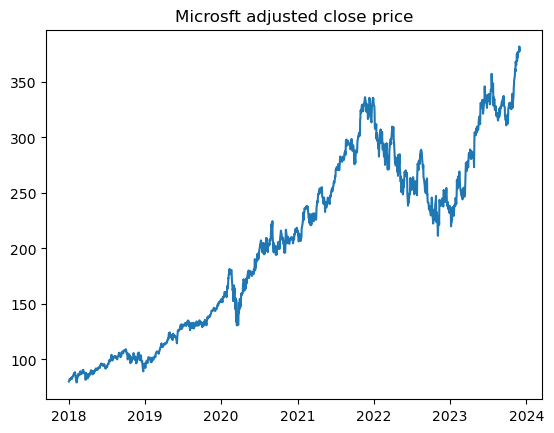

In [95]:
plt.plot(data['Adj Close'])
plt.title('Microsft adjusted close price')

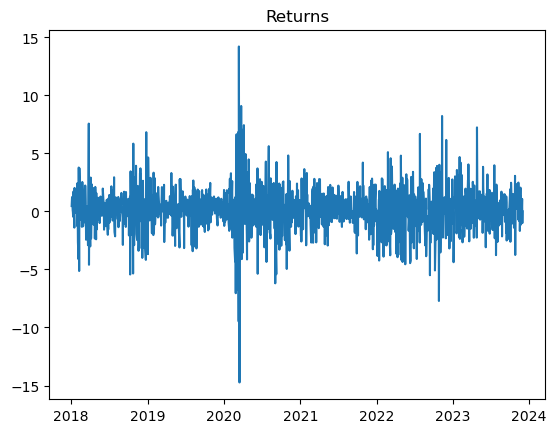

In [96]:
plt.plot(returns)
plt.title('Returns')
plt.show()

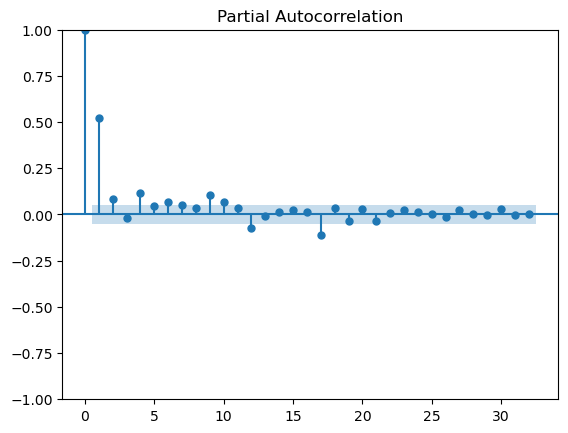

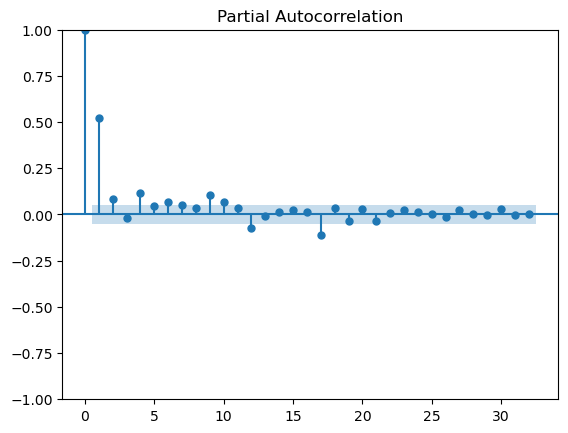

In [97]:
plot_pacf(returns**2)

# GARCH(1, 1)

In [98]:
am = arch_model(returns, p=1, q=1)

In [99]:
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7334.0829436766635
Iteration:      2,   Func. Count:     14,   Neg. LLF: 38307015626.01126
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3287.8512935851872
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3220.2315614323848
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3200.7226812169765
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2875.9673707963348
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2875.933344746042
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2875.929721109699
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2875.9289498981243
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2875.928946975948
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2875.9289469761484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2875.928946975948
            Iterations: 11
            Function evaluations: 65
            Gradient evaluati

In [100]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2875.93
Distribution:                  Normal   AIC:                           5759.86
Method:            Maximum Likelihood   BIC:                           5781.08
                                        No. Observations:                 1488
Date:                Thu, Mar 21 2024   Df Residuals:                     1487
Time:                        15:27:03   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1697  3.865e-02      4.392  1.125e-05 [9.399e-02,  0.245]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1278  6.365e-02      2.008  4.459e-02 [3.088e-03,  0.253]
alpha[1]       0.1506  4.160e-02      3.620  2.943e-04 [6.907e-02,  0.232]
beta[1]        0.8186  5.191e-02     15.769  5.083e-56   [  0.717,  0.920]
==========================================================================

Covariance estimator: robust
"""

# Predictions

In [101]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

def standard_deviation(returns, window, clean=True):
    result = returns.rolling(window=window, center=False).std()
    if clean:
        return result.dropna()
    else:
        return result

rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

We can see that the model captures volatility pretty well both in the first and the second figure.

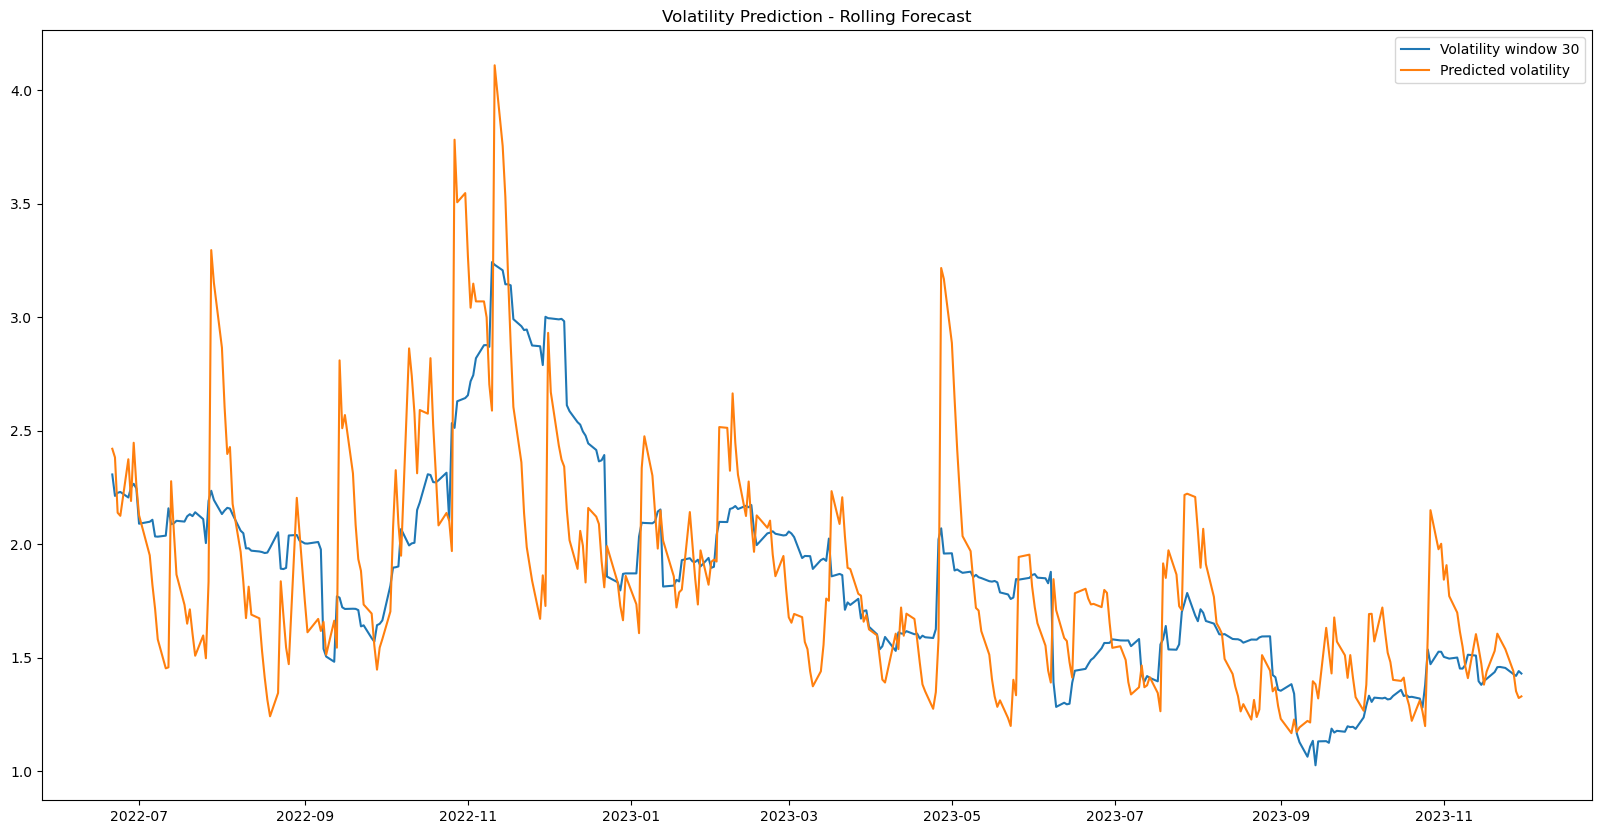

In [102]:
plt.figure(figsize=(20,10))
plt.plot(standard_deviation(returns, 30)[-365:], label='Volatility window 30')
plt.plot(rolling_predictions, label='Predicted volatility')
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend()
plt.show()

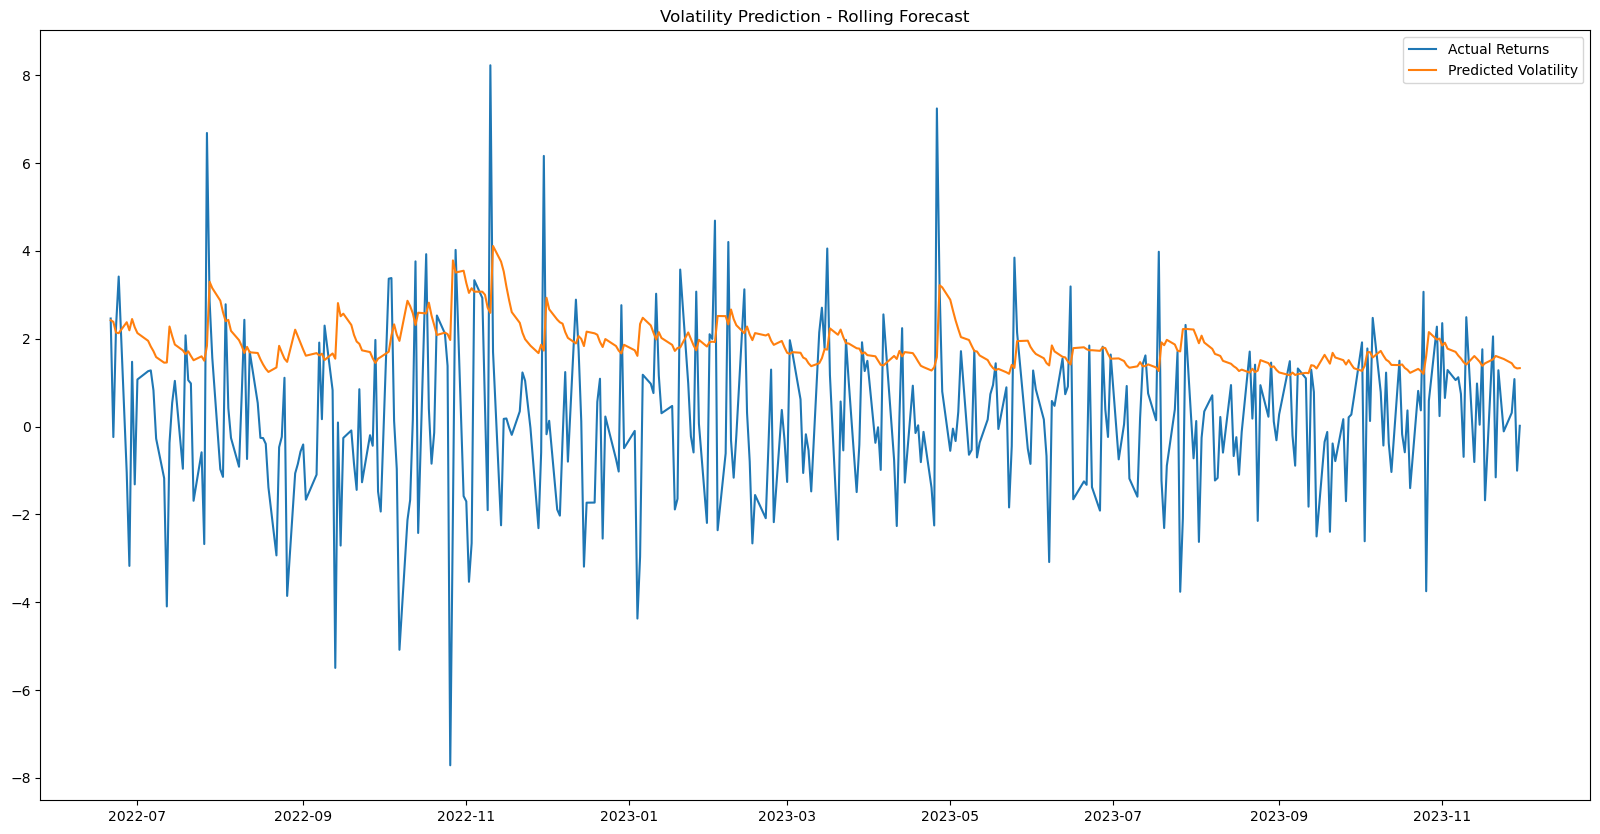

In [103]:
plt.figure(figsize=(20,10))
plt.plot(returns[-365:], label='Actual Returns')
plt.plot(rolling_predictions, label='Predicted Volatility')
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend()
plt.show()